/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_57856/487196296.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be load

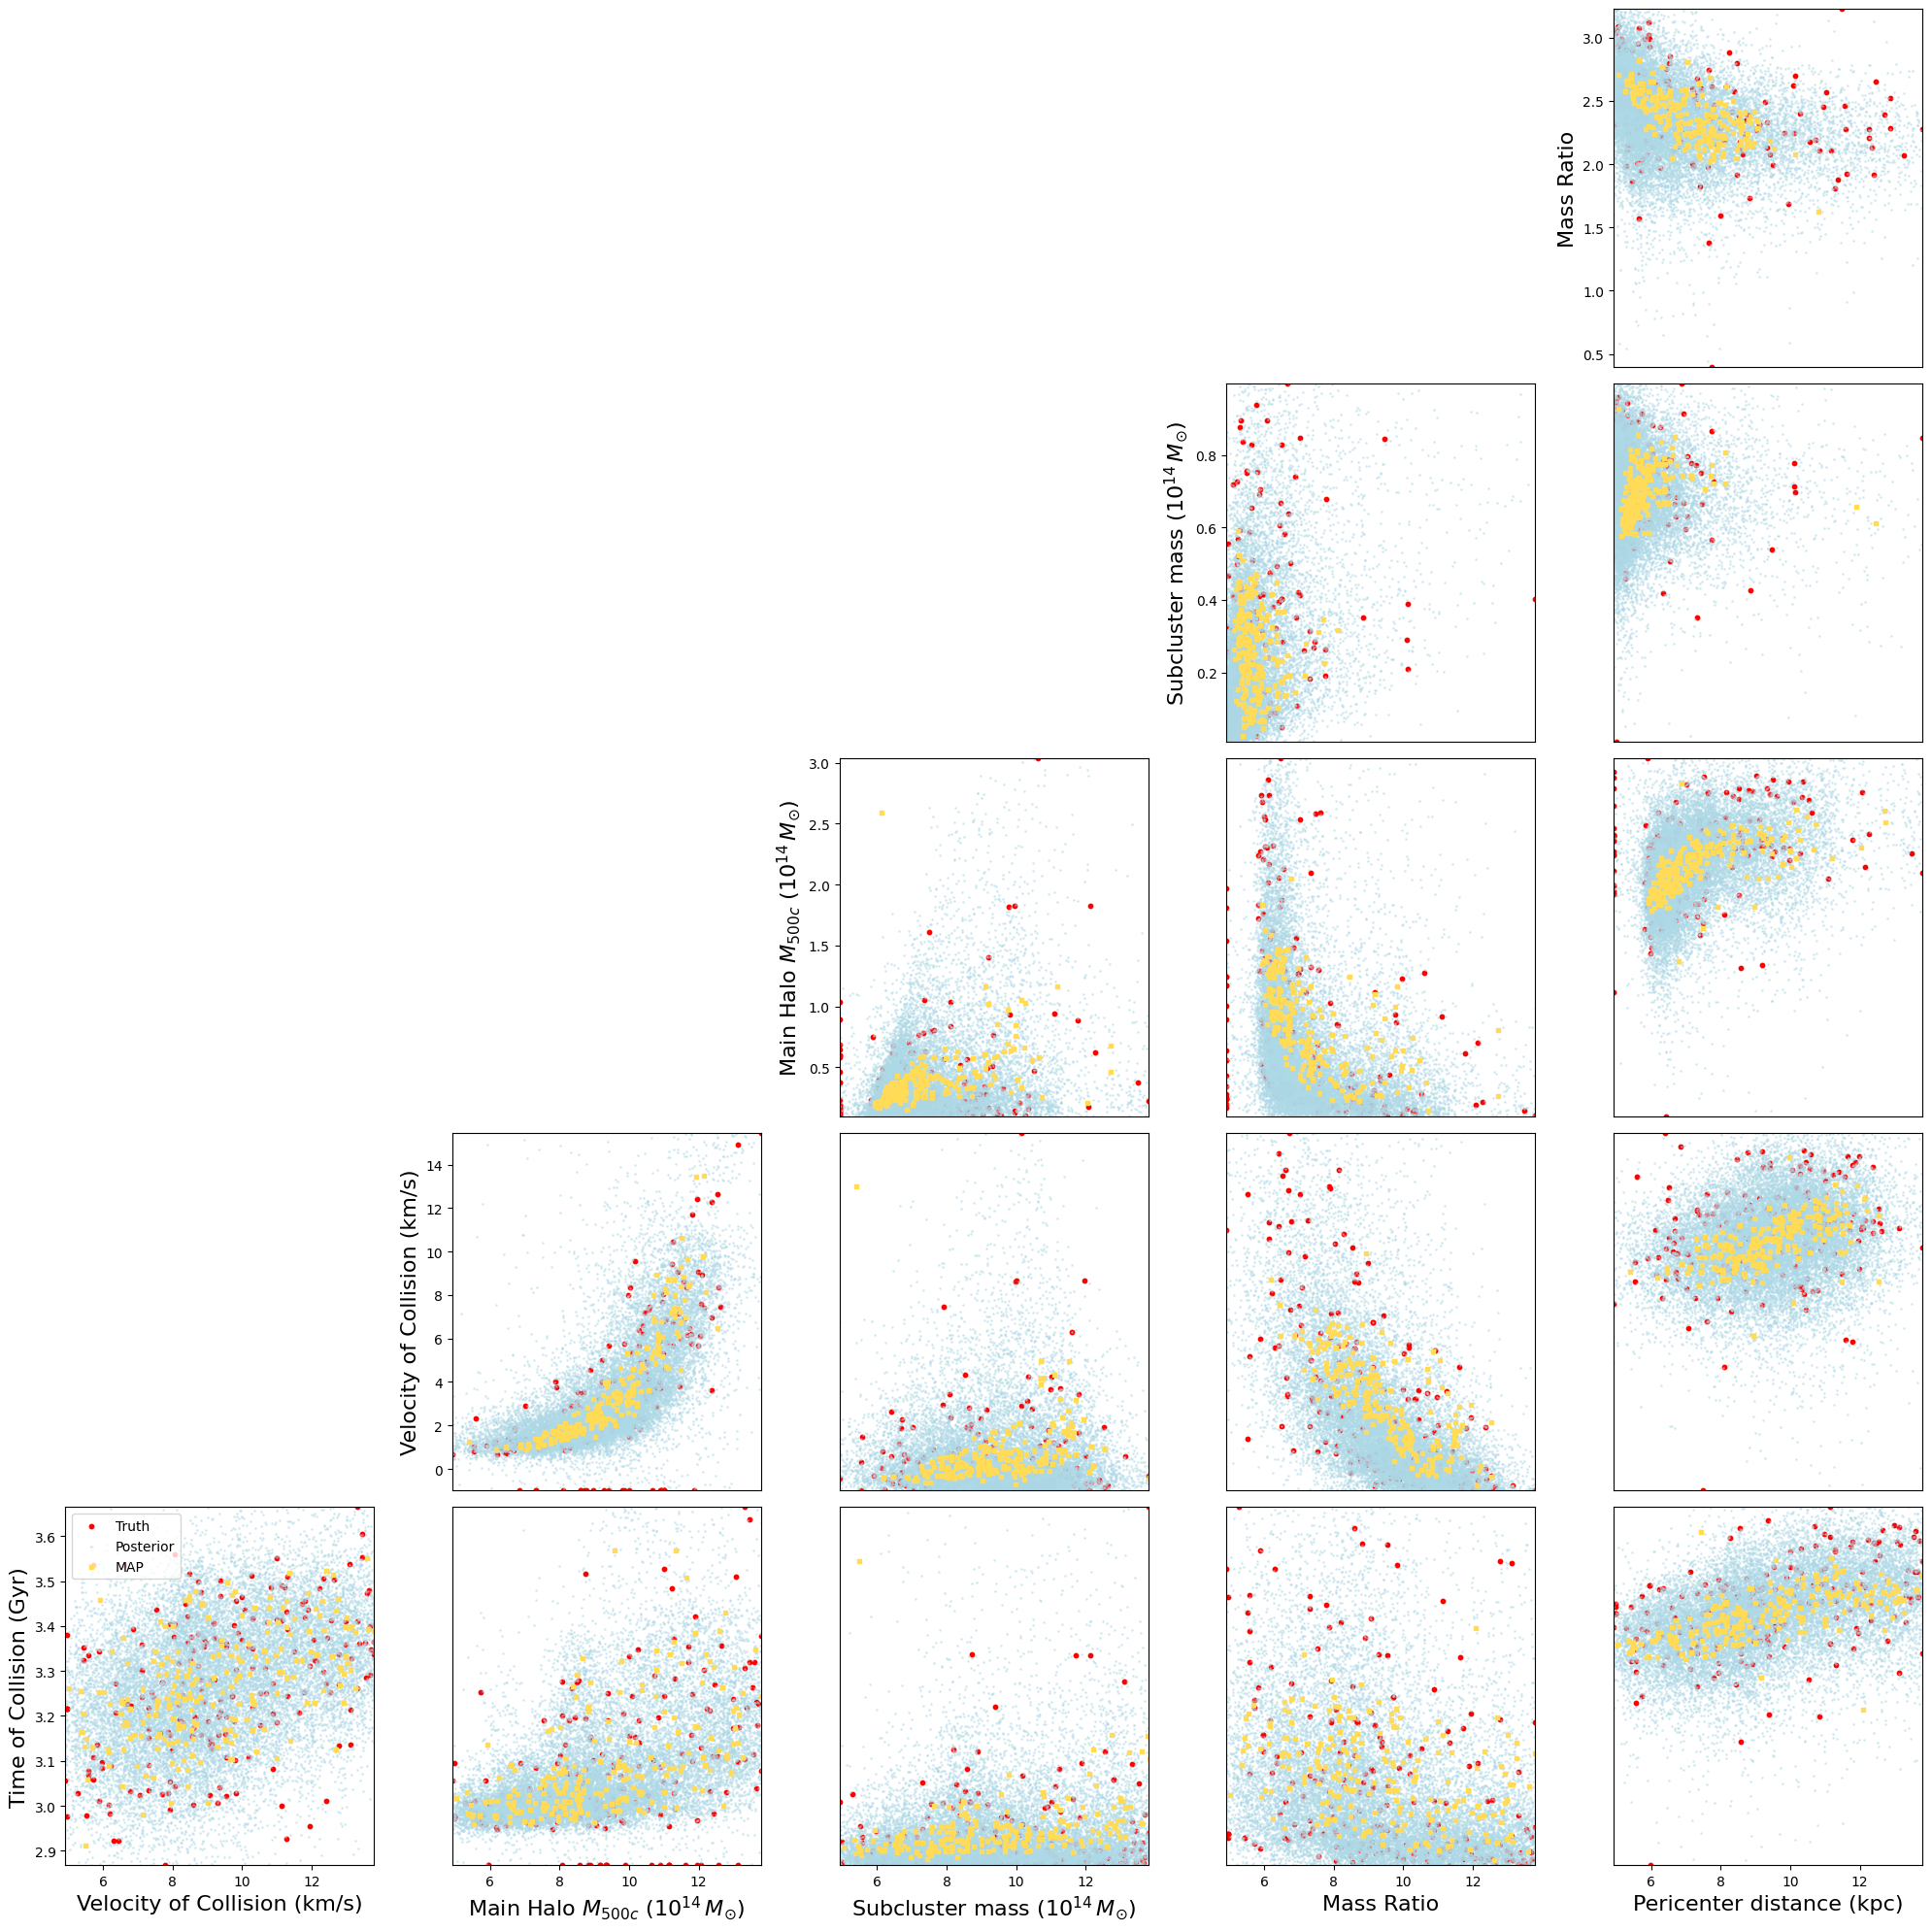

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from model import cINN

TARGET_COLS = [
    'Time of Collision (Gyr)',
    'Velocity of Collision (km/s)',
    r'Main Halo $M_{500c}$ ($10^{14} \, M_{\odot}$)',
    r'Subcluster mass ($10^{14} \, M_{\odot}$)',
    'Mass Ratio',
    'Pericenter distance (kpc)',
]

def plot_pairwise_all_three(model_checkpoint: str,
                            processed_dir: str = "processed_data",
                            n_posterior_samples: int = 600,
                            max_post_samples: int = 20000,
                            random_state: int = 42):
    """
    For each pair of targets (i<j), scatter:
      • Truth (semi-transparent red circles)
      • Posterior draws (opaque light-blue dots)
      • MAP predictions (semi-transparent mustard-yellow squares)
    Arranged in a staircase layout: row i has plots for (i, i+1), (i, i+2), ... 
    """
    # 1) Load & split
    X = pd.read_csv(os.path.join(processed_dir, "X.csv")).values
    Y = pd.read_csv(os.path.join(processed_dir, "Y.csv")).values
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    N, D_obs = X.shape
    _, D_tar = Y.shape
    assert D_tar == len(TARGET_COLS)

    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X[idx_test]
    Y_test = Y[idx_test]
    truth = tar_sc.inverse_transform(Y_test)  # (N_test, D_tar)
    N_test = X_test.shape[0]

    # 2) Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 3) Sample posteriors + compute MAPs
    post_samples = np.zeros((N_test, n_posterior_samples, D_tar))
    maps = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            out = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = out[0] if isinstance(out, tuple) else out
        phys = tar_sc.inverse_transform(Ys.cpu().numpy())
        post_samples[i] = phys
        maps[i] = phys.mean(axis=0)  # MAP proxy

    post_flat = post_samples.reshape(-1, D_tar)

    # 4) Set up a (D_tar-1) × (D_tar-1) grid for the staircase layout
    size = D_tar - 1
    fig, axes = plt.subplots(size, size,
                             figsize=(4 * size, 4 * size),
                             squeeze=False)
    rng = np.random.RandomState(random_state)

    # 5) Plot each pair (i, j) into cell [row=i, col=j-1] for j > i
    for i in range(size):        # rows 0 .. D_tar-2
        for j in range(i+1, D_tar):  # columns i+1 .. D_tar-1
            ax = axes[size-1-i, j-1]
            gt_pts   = truth[:, [i, j]]
            post_pts = post_flat[:, [i, j]]
            map_pts  = maps[:, [i, j]]

            # subsample posterior
            total = post_pts.shape[0]
            if total > max_post_samples:
                idxs = rng.choice(total, max_post_samples, replace=False)
                post_sub = post_pts[idxs]
            else:
                post_sub = post_pts

            # scatter Truth, Posterior, MAP
            ax.scatter(gt_pts[:,0], gt_pts[:,1],
                       c='red', s=10, alpha=1.0)
            ax.scatter(post_sub[:,0], post_sub[:,1],
                       c='lightblue', s=1, alpha=0.4)
            ax.scatter(map_pts[:,0], map_pts[:,1],
                       c='#FFDB58', s=10, marker='s', alpha=1.0)

            # axis limits from ground truth
            ax.set_xlim(gt_pts[:,0].min(), gt_pts[:,0].max())
            ax.set_ylim(gt_pts[:,1].min(), gt_pts[:,1].max())

            # label only the first plot in each row & column
            if j == i+1:
                ax.set_ylabel(TARGET_COLS[i], fontsize=16)
            else:
                ax.set_yticks([])
            if i == 0:
                ax.set_xlabel(TARGET_COLS[j], fontsize=16)
            else:
                ax.set_xticks([])

            # legend only once
            if i == 0 and j == 1:
                ax.legend(['Truth','Posterior','MAP'], loc='upper left')

    # turn off all unused cells below the staircase
    for r in range(size):
        for c in range(size):

            orig_i = size - 1 - r
            orig_j = c + 1

            if orig_j <= orig_i:
                axes[r, c].axis('off')

    plt.tight_layout()
    # save the figure pdf and png
    plt.savefig('4.cross_correlations.png', dpi=300, bbox_inches='tight')
    #plt.savefig('4.cross_correlations.pdf', dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    plot_pairwise_all_three(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        max_post_samples=20000,
        random_state=42
    )
